<a href="https://colab.research.google.com/github/georgezefko/Recommender_System/blob/main/DL_recommender_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [103]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import seaborn as sns
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 
from nltk import sent_tokenize
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings 
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import Input, Reshape, Dot, Add, Activation, Lambda, Concatenate, Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import KFold, StratifiedKFold
from keras.callbacks import ModelCheckpoint
from keras import backend

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [6]:
path ='/content/drive/MyDrive/DTU/ABA'
df = pd.read_csv(path + '/sample.csv')

In [7]:
df

,Unnamed: 0,review_score,price,customer_state,order_status,seller_state,order_item_id,product_category_name_english,customer_unique_id,order_purchase_timestamp,geolocation_lat,geolocation_lng,product_id
0,16295719,1,41.29,SP,canceled,SP,1,home_appliances,595e4f5543fcf93e124729bc947ca896,2018-02-17 09:59:29,-23.677741,-46.668647,f727147ccedba9da38dc2ab8b496a444
1,16295720,1,41.29,SP,canceled,SP,1,home_appliances,595e4f5543fcf93e124729bc947ca896,2018-02-17 09:59:29,-23.676303,-46.668801,f727147ccedba9da38dc2ab8b496a444
2,16295721,1,41.29,SP,canceled,SP,1,home_appliances,595e4f5543fcf93e124729bc947ca896,2018-02-17 09:59:29,-23.683332,-46.672478,f727147ccedba9da38dc2ab8b496a444
3,16295722,1,41.29,SP,canceled,SP,1,home_appliances,595e4f5543fcf93e124729bc947ca896,2018-02-17 09:59:29,-23.675802,-46.670181,f727147ccedba9da38dc2ab8b496a444
4,16295723,1,41.29,SP,canceled,SP,1,home_appliances,595e4f5543fcf93e124729bc947ca896,2018-02-17 09:59:29,-23.677500,-46.670550,f727147ccedba9da38dc2ab8b496a444
...,...,...,...,...,...,...,...,...,...,...,...,...,...
72308,11900298,5,22.00,RO,delivered,SP,3,agro_industry_and_commerce,51d121ddc025c1b70f8f62a1b727aecf,2017-08-30 23:28:35,-23.303878,-45.968478,6ff1fc9209c7854704a4f75c9fac41b4
72309,11900299,5,22.00,RO,delivered,SP,3,agro_industry_and_commerce,51d121ddc025c1b70f8f62a1b727aecf,2017-08-30 23:28:35,-23.307105,-45.970192,6ff1fc9209c7854704a4f75c9fac41b4
72310,11900300,5,22.00,RO,delivered,SP,3,agro_industry_and_commerce,51d121ddc025c1b70f8f62a1b727aecf,2017-08-30 23:28:35,-23.299062,-45.965588,6ff1fc9209c7854704a4f75c9fac41b4
72311,11900301,5,22.00,RO,delivered,SP,3,agro_industry_and_commerce,51d121ddc025c1b70f8f62a1b727aecf,2017-08-30 23:28:35,-23.298785,-45.966985,6ff1fc9209c7854704a4f75c9fac41b4


In [8]:
df.review_score.value_counts()

5    42547
4    13860
1     8154
3     5834
2     1918
Name: review_score, dtype: int64

# Recommender ANN

Based on https://medium.com/@jdwittenauer/deep-learning-with-keras-recommender-systems-e7b99cb29929


In [9]:
class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        return x

In [72]:
def RecommenderNet(n_customers, n_items, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_customers, n_factors)(user)
    
    item = Input(shape=(1,))
    m = EmbeddingLayer(n_items, n_factors)(item)
    
    x = Concatenate()([u, m])
    x = Dropout(0.05)(x)
    
    x = Dense(50, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(5, kernel_initializer='he_normal')(x)
    x = Activation('softmax')(x)
    #x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    model = Model(inputs=[user, item], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [109]:
df_keras = df.loc[:,'customer_unique_id,product_id,review_score,order_purchase_timestamp'.split(',')]


In [110]:
customer_enc = LabelEncoder()
df_keras['customer'] = customer_enc.fit_transform(df_keras.customer_unique_id.values)
n_customers = df_keras.customer.nunique()
item_enc = LabelEncoder()
df_keras['item'] = item_enc.fit_transform(df_keras.product_id.values)
n_items = df_keras.item.nunique()

rating_enc = LabelEncoder()
df_keras['rating'] = rating_enc.fit_transform(df_keras.review_score.values)
min_rating = min(df_keras.rating)
max_rating = max(df_keras.rating)
n_customers, n_items, min_rating, max_rating

(453, 158, 0, 4)

In [111]:
X = df_keras[['customer', 'item']].values
y = df_keras['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((48449, 2), (23864, 2), (48449,), (23864,))

In [112]:
n_factors = 50 #first hyperparameter to tune

X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [113]:
model = RecommenderNet(n_customers, n_items, n_factors, min_rating, max_rating)
history = model.fit(x=X_train_array, y=y_train, batch_size=512, epochs=10,
                    verbose=1, validation_data=(X_test_array, y_test))

Epoch 1/10
95/95 [==============================] - 1s 8ms/step - loss: 1.3433 - accuracy: 0.5030 - val_loss: 0.4437 - val_accuracy: 0.8944
Epoch 2/10
95/95 [==============================] - 1s 6ms/step - loss: 0.3432 - accuracy: 0.9136 - val_loss: 0.0720 - val_accuracy: 0.9909
Epoch 3/10
95/95 [==============================] - 1s 6ms/step - loss: 0.0833 - accuracy: 0.9859 - val_loss: 0.0201 - val_accuracy: 0.9940
Epoch 4/10
95/95 [==============================] - 1s 6ms/step - loss: 0.0376 - accuracy: 0.9924 - val_loss: 0.0130 - val_accuracy: 0.9938
Epoch 5/10
95/95 [==============================] - 1s 6ms/step - loss: 0.0248 - accuracy: 0.9927 - val_loss: 0.0112 - val_accuracy: 0.9941
Epoch 6/10
95/95 [==============================] - 1s 6ms/step - loss: 0.0203 - accuracy: 0.9934 - val_loss: 0.0108 - val_accuracy: 0.9939
Epoch 7/10
95/95 [==============================] - 1s 6ms/step - loss: 0.0179 - accuracy: 0.9933 - val_loss: 0.0107 - val_accuracy: 0.9939
Epoch 8/10
95/95 [==

In [114]:
y_pred = model.predict(X_test_array)#.astype(int).flatten()
y_pred = np.argmax(y_pred, axis=1)

In [78]:
def plot_confusion_matrix(test_labels, predicted_labels, save_path=None, encoder=None):
    if encoder:
      test_labels = encoder.inverse_transform(test_labels)
      predicted_labels = encoder.inverse_transform(predicted_labels)

    conf_matrix = confusion_matrix(test_labels, predicted_labels)
    conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=[10, 10], dpi=100)
    im = ax.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    classes = unique_labels(test_labels, predicted_labels)
    ax.set(xticks=np.arange(conf_matrix.shape[1]),
           yticks=np.arange(conf_matrix.shape[0]),
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')
    fmt = '.3f'
    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(j, i, format(conf_matrix[i, j], fmt),
                    ha="center", va="center",
                    color="white" if conf_matrix[i, j] > thresh else "black")
    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

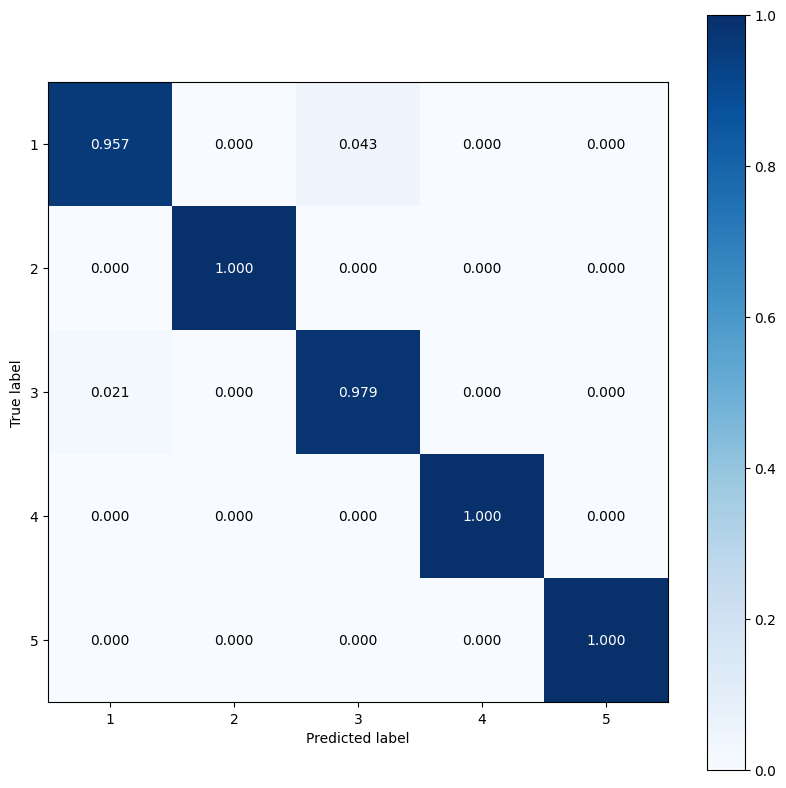

In [80]:
plot_confusion_matrix(y_test, y_pred, encoder=rating_enc)


# Cross validation
Based on https://medium.com/the-owl/k-fold-cross-validation-in-keras-3ec4a3a00538

In [122]:
n_splits = 5
kf = KFold(n_splits, shuffle=True)

In [89]:
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

In [116]:

VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

for fold_var, (train_index, val_index) in enumerate(kf.split(X,y)):
  X_train = X[train_index]
  X_test = X[val_index]

  X_train_array = [X_train[:, 0], X_train[:, 1]]
  X_test_array = [X_test[:, 0], X_test[:, 1]] 

  y_train = y[train_index]
  y_test = y[val_index]

  model = RecommenderNet(n_customers, n_items, n_factors, min_rating, max_rating)
  
  
  checkpoint = ModelCheckpoint(path+'/saved_models/'+get_model_name(fold_var), 
							monitor='val_accuracy', verbose=1, 
							save_best_only=True, mode='max')
  callbacks_list = [checkpoint]

  history = model.fit(x=X_train_array, y=y_train, batch_size=512, epochs=10,
                    verbose=1, validation_data=(X_test_array, y_test), callbacks=callbacks_list)
  
  model.load_weights(path+"/saved_models/model_"+str(fold_var)+".h5")
  
  results = model.evaluate(X_test_array, y_test)
  results = dict(zip(model.metrics_names,results))
	
  VALIDATION_ACCURACY.append(results['accuracy'])
  VALIDATION_LOSS.append(results['loss'])
  
  backend.clear_session()

Epoch 1/10
113/113 [==============================] - 1s 7ms/step - loss: 1.2282 - accuracy: 0.5747 - val_loss: 0.2503 - val_accuracy: 0.9527

Epoch 00001: val_accuracy improved from -inf to 0.95271, saving model to /content/drive/MyDrive/DTU/ABA/saved_models/model_0.h5
Epoch 2/10
113/113 [==============================] - 1s 6ms/step - loss: 0.1978 - accuracy: 0.9569 - val_loss: 0.0390 - val_accuracy: 0.9911

Epoch 00002: val_accuracy improved from 0.95271 to 0.99108, saving model to /content/drive/MyDrive/DTU/ABA/saved_models/model_0.h5
Epoch 3/10
113/113 [==============================] - 1s 6ms/step - loss: 0.0546 - accuracy: 0.9905 - val_loss: 0.0157 - val_accuracy: 0.9932

Epoch 00003: val_accuracy improved from 0.99108 to 0.99315, saving model to /content/drive/MyDrive/DTU/ABA/saved_models/model_0.h5
Epoch 4/10
113/113 [==============================] - 1s 6ms/step - loss: 0.0276 - accuracy: 0.9939 - val_loss: 0.0124 - val_accuracy: 0.9934

Epoch 00004: val_accuracy improved fro

In [118]:
VALIDATION_ACCURACY = np.array(VALIDATION_ACCURACY)

In [123]:
print(f'Mean accuracy of the {n_splits}-split cross validation: {VALIDATION_ACCURACY.mean():.2f}({VALIDATION_ACCURACY.std():.2f})')

Mean accuracy of the 5-split cross validation: 0.99(0.00)
